# Data Analysis & Conclusions

_Notebook credits:_ Harshit Garg

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [2]:
def convert_date_time(date_dict):
    date_dict = json.loads(date_dict)
    dt = datetime(
        year=date_dict['Year'],
        month=date_dict['Month'],
        day=date_dict['Day'],
        hour=date_dict['Hour'],
        minute=date_dict['Minute'],
        second=date_dict['Second']
    )
    return dt

In [3]:
df = pd.read_parquet("/kaggle/input/wikinews-topic-modeling-using-bertopic-stage-4/topical_output.parquet")
# df = df.drop('page_dates', axis=1)
# df = df.drop("page_dates_parsed", axis = 1)
# df = df.drop("last_update_timestamp", axis = 1)
df['last_update_timestamp_obj'] = df['last_update_timestamp_obj'].map(convert_date_time)
df['page_dates_parsed_obj'] = df['page_dates_parsed_obj'].map(convert_date_time)
df_json = pd.read_json("/kaggle/input/wikinews-topic-modeling-using-bertopic-stage-4/topics.json",orient="index")
df_json["assigned_topic_num"] = range(-1, len(df_json)-1)
df_json = df_json.rename(columns={0:"topic", 1:"topic_popularity"})
df_final = pd.merge(df, df_json, how="left", on="assigned_topic_num")
df_final

,page_title,page_dates,page_text_extract_result,assigned_topic_num,topic_probability,page_dates_parsed_obj,last_update_timestamp_obj,topic,topic_popularity
0,President of China lunches with Brazilian Pres...,"[{{date|november 13, 2004}}]","Saturday, November 13, 2004 \n\nHu Jintao, the...",80,1.000000,2004-11-13,2019-09-28 09:51:53,brazilian,0.038502
1,Palestinians to elect new president on January 9,"[{{byline|date=november 14, 2004|location=[[w:...","Sunday, November 14, 2004 \nRAMALLAH — Acting ...",230,0.915818,2004-11-14,2019-09-28 10:45:51,abbas,0.036603
2,Brazilian delegation returns from Arafat funeral,"[{{date|november 13, 2004}}]","Saturday, November 13, 2004 \n\nThe delegation...",80,0.668489,2004-11-13,2014-01-02 19:36:05,brazilian,0.038502
3,Hearing begins over David Hookes death,"[{{byline|date=november 15, 2004|location=[[me...","Monday, November 15, 2004 \nMELBOURNE, Victori...",1,0.875391,2004-11-15,2019-09-28 10:39:36,police,0.012578
4,Iran close to decision on nuclear program,"[{{date|november 13, 2004}}]","Saturday, November 13, 2004 \n\nIranian repres...",9,0.782153,2004-11-13,2013-08-21 16:07:41,iran,0.044528
...,...,...,...,...,...,...,...,...,...
14502,Smithsonian National Zoo euthanizes elderly As...,"[{{date|november 7, 2024}}]","Thursday, November 7, 2024 \n\nKamala, an Asia...",258,1.000000,2024-11-07,2024-11-17 15:43:17,elephant,0.051680
14503,Trump declares victory,"[{{date|november 6, 2024}}]","Wednesday, November 6, 2024 \n\nDonald Trump i...",81,0.576288,2024-11-06,2024-11-16 16:19:37,trump,0.033700
14504,"Trump wins 2024 U.S. Presidential Election, se...","[{{date|november 12, 2024}}]","Tuesday, November 12, 2024 \n\nDonald Trump w...",81,0.988270,2024-11-12,2024-11-12 18:11:08,trump,0.033700
14505,"Prison riot in Ecuador, at least 17 killed","[{{date|november 13, 2024}}]","Wednesday, November 13, 2024 \n\nAt least sev...",79,0.890278,2024-11-13,2024-11-17 16:35:30,brazilian,0.024508


## Share of all topics across all articles

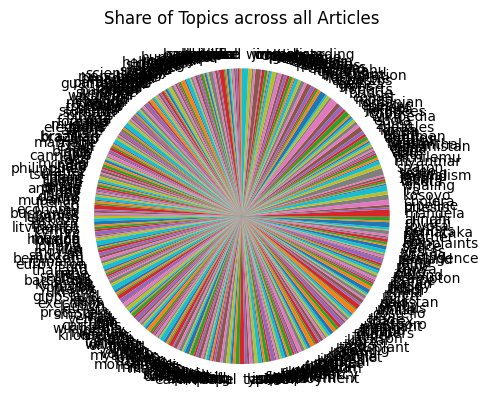

In [4]:
plt.pie(df_json['topic_popularity'], labels=df_json['topic'], startangle=90)
plt.title('Share of Topics across all Articles')
plt.show()

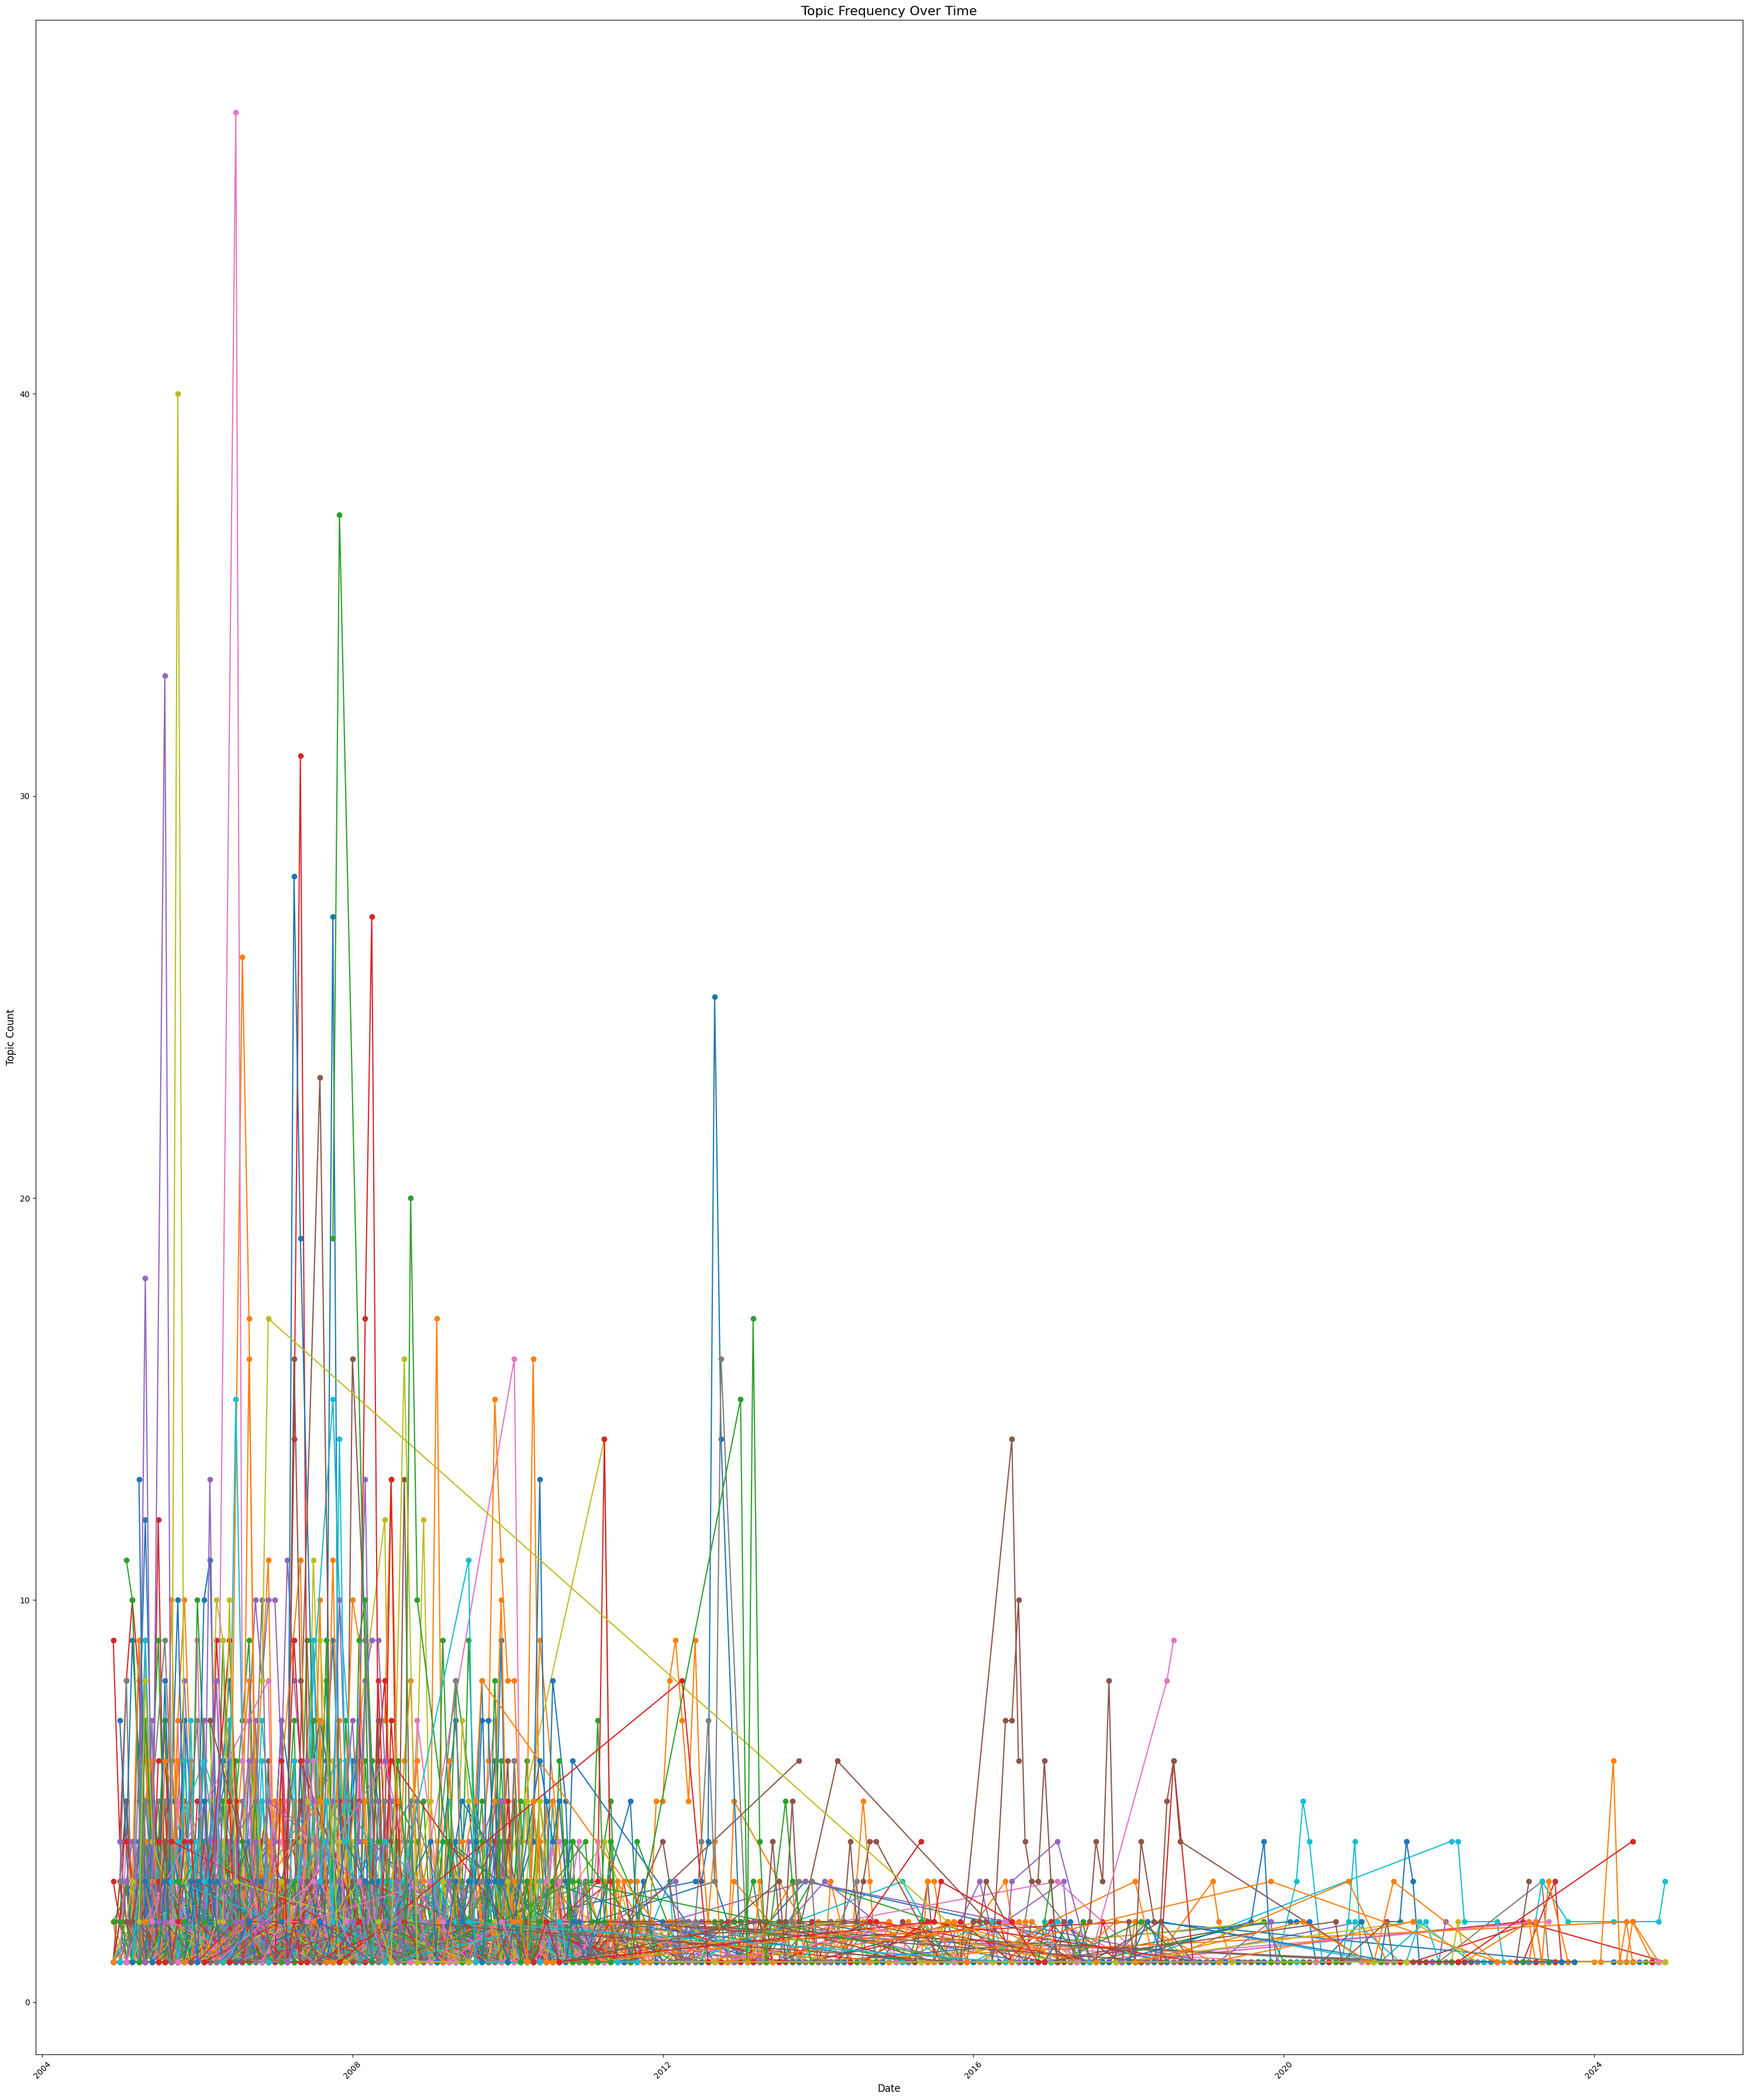

In [5]:
import hashlib

topic_counts = df_final.copy().groupby([pd.Grouper(key='page_dates_parsed_obj', freq="1ME"), 'topic']).agg(count=("page_title", "count"))
topic_counts = topic_counts.reset_index()

plt.figure(figsize=(30, 36))
def hash_color(topic):
    hash_object = hashlib.sha256(topic.encode('utf-8'))
    hex_digest = hash_object.hexdigest()
    color_hex = hex_digest[:6]
    return "#" + color_hex

for topic in topic_counts['topic'].unique():
    topic_data = topic_counts[topic_counts['topic'] == topic]
    plt.plot(topic_data['page_dates_parsed_obj'], topic_data['count'], marker='o', label=topic)

plt.title('Topic Frequency Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Topic Count', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if dates are numerous

plt.tight_layout()
plt.show()

Here are the 10 most common topics overall:

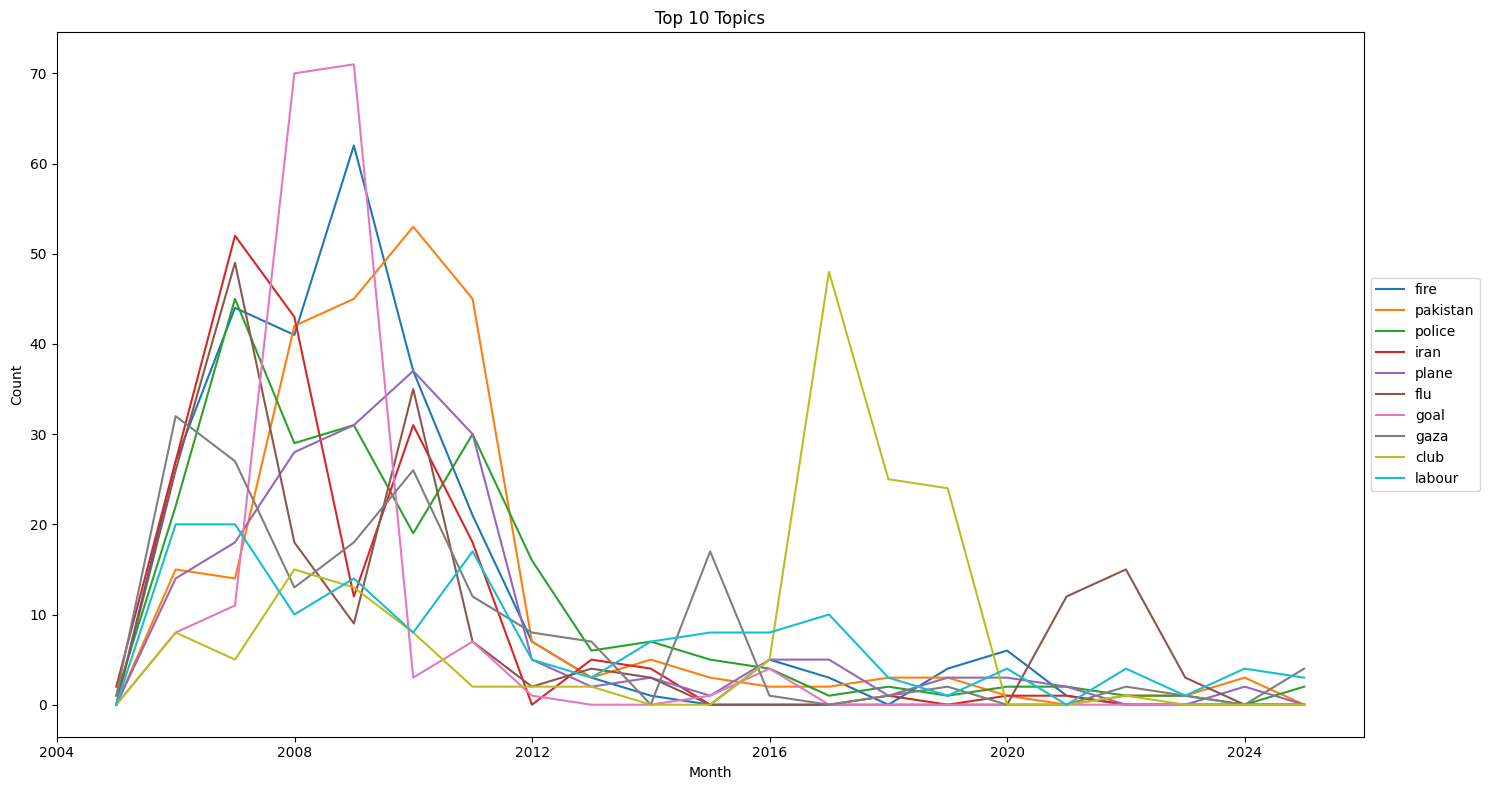

In [6]:
topic_monthly_counts = df_final.groupby([pd.Grouper(key='page_dates_parsed_obj', freq='1YE'), 'topic']).size().unstack(fill_value=0)
top_n = 10  # Plot the top 10 most frequent topics
top_topics = topic_monthly_counts.sum().sort_values(ascending=False).head(top_n).index

plt.figure(figsize=(15, 8))
for topic in top_topics:
    plt.plot(topic_monthly_counts[topic].index, topic_monthly_counts[topic], label=topic)
plt.title(f'Top {top_n} Topics')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

We can also use sentiment analysis to determine what the average sentiment of a topic is, and use this to plot the average sentiment of topics over time. Most articles, surprisingly enough, tended to be neutral, but we can see spikes where positive or negative articles tended to be more common. The fact that most articles are neutral is likely a reflection of the fact that Wikipedia has relatively strong moderation around making sure that wikipedia articles are neutral with respect to topics they cover.

WikiNews itself also seems to be less popular now than it was around the time of its creation and between 2006-2010.

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


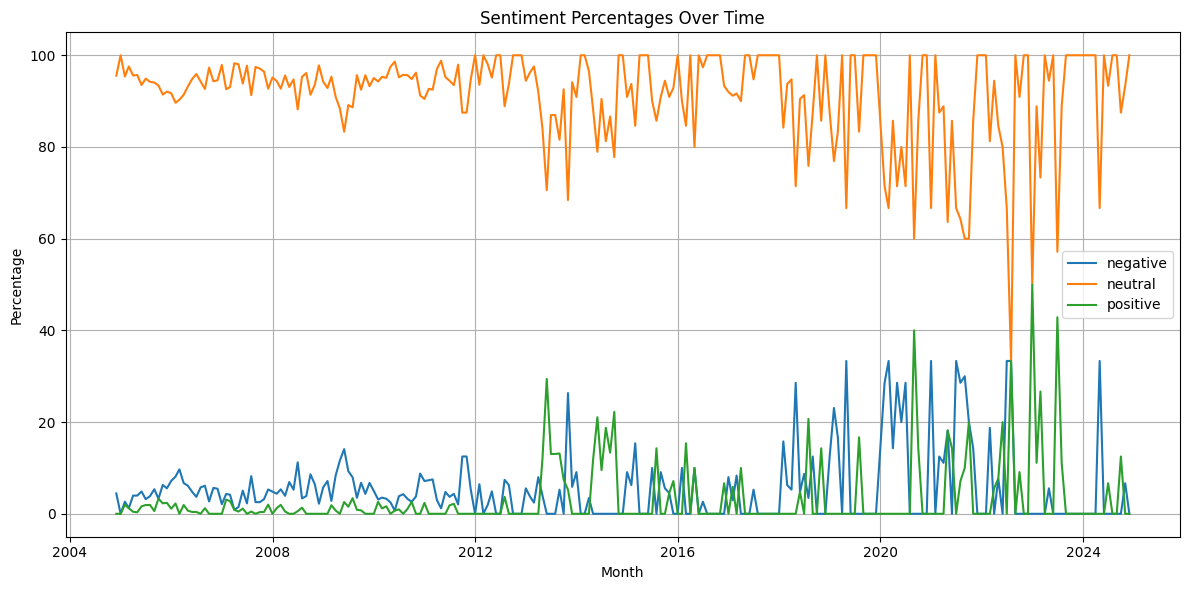

In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def map_polarity_score(x):
    if x["pos"] == 1.0:
        return "positive"
    elif x["neg"] == 1.0:
        return "negative"
    else:
        return "neutral"

analyzer = SentimentIntensityAnalyzer()
df_final["topic_sentiment"] = [map_polarity_score(analyzer.polarity_scores(t)) for t in df_final["topic"]]

def plot_sentiment_time_series(df, date_column, sentiment_column):
    # Group by month and calculate sentiment totals
    sentiment_counts = df.groupby([pd.Grouper(key=date_column, freq='1ME'), sentiment_column]).size().unstack(fill_value=0)
    monthly_totals = sentiment_counts.sum(axis=1)

    sentiment_percentages = sentiment_counts.div(monthly_totals, axis=0) * 100

    # Plot the time series
    plt.figure(figsize=(12, 6))
    for sentiment in sentiment_percentages.columns:
        plt.plot(sentiment_percentages.index, sentiment_percentages[sentiment], label=sentiment)
    plt.title("Sentiment Percentages Over Time")
    plt.xlabel("Month")
    plt.ylabel("Percentage")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sentiment_time_series(df_final, 'page_dates_parsed_obj', 'topic_sentiment')

## Average Time Between Initial Publication and Latest Edit

7085 days 19:00:07
0 days 00:06:40
2321 days 15:48:12.817812096


Text(0, 0.5, '# of articles')

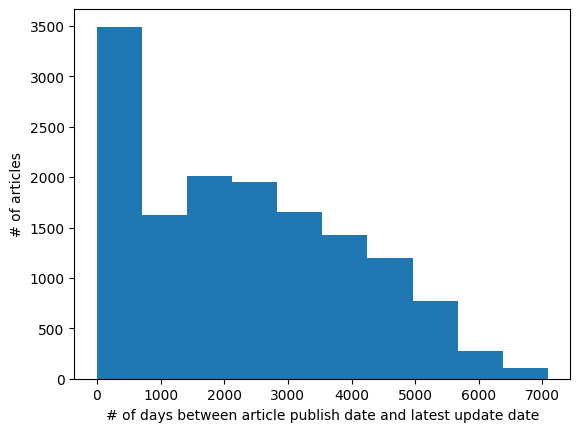

In [8]:
#average time between intial publication and update
df_final["time_between_upload_and_edit"] = df_final["last_update_timestamp_obj"] - df_final["page_dates_parsed_obj"]
print(max(df_final["time_between_upload_and_edit"]))
print(min(df_final["time_between_upload_and_edit"]))
print(np.mean(df_final["time_between_upload_and_edit"]))
plt.hist(df_final["time_between_upload_and_edit"] // np.timedelta64(1, 'D'))
plt.xlabel("# of days between article publish date and latest update date")
plt.ylabel("# of articles")

In [9]:
print("Minimum Time between Upload and Edit:")
display(df_final[df_final["time_between_upload_and_edit"] == df_final["time_between_upload_and_edit"].max()])

Minimum Time between Upload and Edit:


,page_title,page_dates,page_text_extract_result,assigned_topic_num,topic_probability,page_dates_parsed_obj,last_update_timestamp_obj,topic,topic_popularity,topic_sentiment,time_between_upload_and_edit
385,Romania plans its next privatisation initiatives,"[{{date|february 21, 2005}}]","Monday, February 21, 2005 \nThe Romanian Gover...",115,0.81066,2005-02-21,2024-07-16 19:00:07,bucharest,0.038244,neutral,7085 days 19:00:07


In [10]:
print("Maximum Time between Upload and Edit:")
display(df_final[df_final["time_between_upload_and_edit"] == df_final["time_between_upload_and_edit"].min()])

Maximum Time between Upload and Edit:


,page_title,page_dates,page_text_extract_result,assigned_topic_num,topic_probability,page_dates_parsed_obj,last_update_timestamp_obj,topic,topic_popularity,topic_sentiment,time_between_upload_and_edit
14471,Azov Brigade to be allowed to use US weapons,"[{{date|june 16, 2024}}]","Sunday, June 16, 2024 \nOn Monday, the United ...",147,1.0,2024-06-16,2024-06-16 00:06:40,ukraine,0.047922,neutral,0 days 00:06:40


We can see that the average WikiNews article does tend to be updated with new edits, potentially months or years after its creation.